In [1]:
import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from histo_utilities import create_TH1D, create_TH2D, std_color_list

# import CMS_lumi, tdrstyle
# tdrstyle.setTDRStyle()
# CMS_lumi.writeExtraText = 1
# CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.13/02


In [70]:
fpath = {}
tree = {}
process = {}
process_short = {}


#fpath['m50ct10000mm'] = '/Users/cmorgoth/llp_ntupler_gen_info.root'
fpath['qcd'] = '/Users/cmorgoth/qcd_llp_ntupler.root'
fpath['m50ct10000mm'] = '/Users/cmorgoth/llp_ntupler_mh125_mx50_pl10000_ALL.root'
process['glueBall'] = 'pp #rightarrow h*h* #rightarrow jj#nu#nu'
process_short['glueBall'] = 'pp #rightarrow h*h* #rightarrow jj#nu#nu'

print process
print process_short


for k,v in fpath.iteritems():
    print k, v
    tree[k] = rtnp.root2array(v)
    #tree[k] = rtnp.tree2array(v)
    #jet_max_pt_array = [np.max(x) for x in tree[k]["jetPt"]]
    a = tree[k]["gLLP_decay_vertex_z"]
    print a[:-1][0]

{'glueBall': 'pp #rightarrow h*h* #rightarrow jj#nu#nu'}
{'glueBall': 'pp #rightarrow h*h* #rightarrow jj#nu#nu'}
m50ct10000mm /Users/cmorgoth/llp_ntupler_mh125_mx50_pl10000_ALL.root
[ 290.65445 -304.07755]
qcd /Users/cmorgoth/qcd_llp_ntupler.root
[-666. -666.]


In [71]:
#T = tree['glueBall']
T = tree['m50ct10000mm']
T_bkg = tree['qcd']

In [72]:
#get first jet pt per event
print T['jetPt']
first_jet_pt = [x[0] if len(x) else -1 for x in T['jetPt']]
#print first_jet_pt

[array([32.053577], dtype=float32) array([], dtype=float32)
 array([], dtype=float32) ... array([45.861034], dtype=float32)
 array([24.10495], dtype=float32) array([], dtype=float32)]


In [73]:
#get max jet pt per event
max_jet_pt = [np.max(np.abs(x)) if len(x) else -1 for x in T['gLLP_decay_vertex_z']]
#print max_jet_pt

In [74]:
#store jet-pt array per event in a list
first_jet_pt_arr = []
for x in T['jetPt']:
    if len(x) == 0:
        break
    #print x
    first_jet_pt_arr.append(x[0])

In [75]:
MAX_ITERATIONS = 100
# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
def shouldStop(oldCentroids, centroids, iterations):
    if iterations > MAX_ITERATIONS: return True
    return np.array_equal(oldCentroids,centroids)


# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
def getLabels(dataSet, centroids):
    #print 1
    #for i in dataSet:
    dist = cdist( dataSet, centroids, metric='euclidean' )
    #print dist
    return np.argmin(dist, axis=1)
    #print dataSet
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.

# Function: Get Centroids
# -------------
# Returns k centroids, each of dimension n.
def getCentroids(dataSet, centroids, labels, k):
    #print centroids
    newcentroid = []
    centroid_constituents = []
    for i in range(k):
        sel = labels[:] == i
        #print i, dataSet[sel], np.count_nonzero(dataSet[sel])/2
        if np.count_nonzero(dataSet[sel]) > 0:
            #print np.average(dataSet[sel], axis=0)
            newcentroid.append(np.average(dataSet[sel], axis=0))
            centroid_constituents.append(np.count_nonzero(dataSet[sel])/2)
        else:
            newcentroid.append(centroids[i])
            centroid_constituents.append(0)
    #print 'new:', centroid_constituents
    return newcentroid, centroid_constituents
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    
# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
def getRandomCentroids(numFeatures, k):
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    return np.random.rand(k,numFeatures)

# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
def kmeans(dataSet, k):
    # Initialize centroids randomly
    numFeatures = dataSet.ndim
    centroids = getRandomCentroids(numFeatures, k)
    #print numFeatures, k, centroids
    
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.zeros((k,numFeatures))
    
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids[:] = centroids
        #print oldCentroids
        iterations += 1
        #print 'iter', iterations
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids)
        #print labels
        #print oldCentroids
        #print '====================='
        
        
        # Assign centroids based on datapoint labels
        centroids,centroid_constituents = getCentroids(dataSet, oldCentroids, labels, k)
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids,centroid_constituents

[False False False ... False False False]
4
4


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


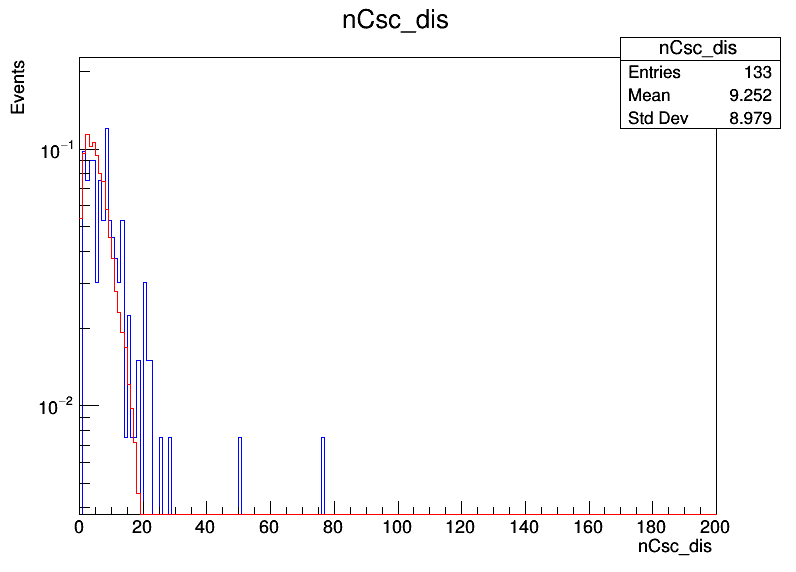

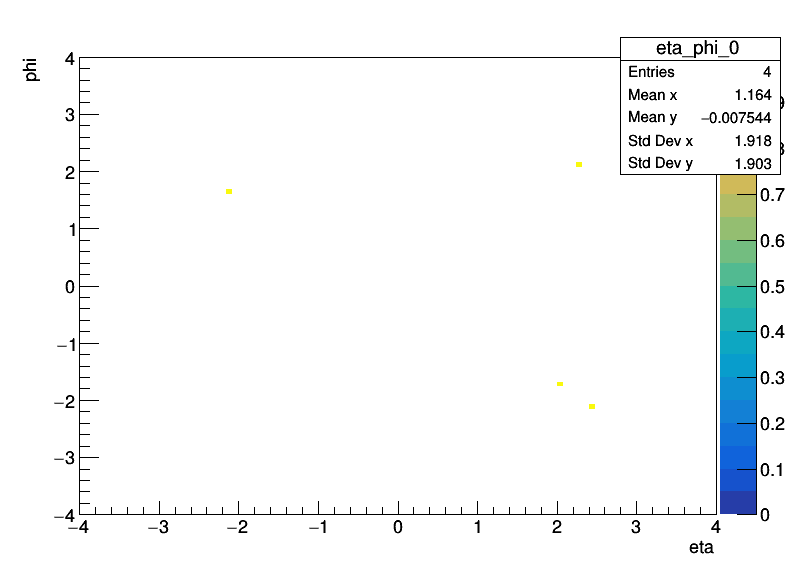

In [83]:
#Create Numpy Arrays for (['cscEta', 'cscPhi', 'cscX', 'cscY']) w
four_highest_jet_var = {}

#for v in ['jetPt', 'jetEta', 'jetPhi', 'jetE']:
#    tmp = []
#print T['gLLP_decay_vertex_z']
#print T['gLLP_decay_vertex_z'][:,0]

##ORIGINAL
sel_dis1 = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,0]) > 500 , np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 1000, np.absolute(T['gLLP_decay_vertex_z'][:,1]) < 100)
sel_dis2 = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,1]) > 500 , np.absolute(T['gLLP_decay_vertex_z'][:,1]) < 1000, np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 100)
sel_dis3 = np.sqrt(T['gLLP_decay_vertex_x'][:,0]*T['gLLP_decay_vertex_x'][:,0] + T['gLLP_decay_vertex_y'][:,0]*T['gLLP_decay_vertex_y'][:,0]) < 100
sel_dis4 = np.sqrt(T['gLLP_decay_vertex_x'][:,1]*T['gLLP_decay_vertex_x'][:,1] + T['gLLP_decay_vertex_y'][:,1]*T['gLLP_decay_vertex_y'][:,1]) < 100
sel_dis12 = np.logical_or(sel_dis1,sel_dis2)
sel_dis34 = np.logical_and(sel_dis3,sel_dis4)

#sel_prompt = np.logical_and( np.absolute(T['gLLP_decay_vertex_z'][:,0]) < 100 , np.absolute(T['gLLP_decay_vertex_z'][:,1]) < 100)
#sel_displaced =  np.logical_or(sel_dis1,sel_dis2)

#print T['jetPt'].shape
#sel_dis1 = [True if x.any > 50 else False for x in T['jetPt']]
#sel_dis2 = [True if x.any > 50 else False for x in T['jetPt']]
sel_prompt = [True if x.any > 50 else False for x in T_bkg['jetPt']]
sel_displaced =  np.logical_and(sel_dis12,sel_dis34)

print sel_displaced

csc_eta_dis = T['cscEta'][sel_displaced]
csc_phi_dis = T['cscPhi'][sel_displaced]
csc_x_dis = T['cscX'][sel_displaced]
csc_y_dis = T['cscY'][sel_displaced]
csc_z_dis = T['cscZ'][sel_displaced]
nCsc_dis = T['nCsc'][sel_displaced]

csc_eta_prompt = T_bkg['cscEta'][sel_prompt]
csc_phi_prompt = T_bkg['cscPhi'][sel_prompt]
csc_x_prompt = T_bkg['cscX'][sel_prompt]
csc_y_prompt = T_bkg['cscY'][sel_prompt]
csc_z_prompt = T_bkg['cscZ'][sel_prompt]
nCsc_prompt = T_bkg['nCsc'][sel_prompt]

#print nCsc_dis.ndim, nCsc_dis.shape, nCsc_dis.size
#print np.vstack((csc_eta_dis[0],csc_phi_dis[0])).T.ndim
evt_idx = 15
c = rt.TCanvas('c','c', 800, 600)
h = {}
h['nCsc_dis'] = create_TH1D(nCsc_dis, axis_title=['nCsc_dis', 'Events'], name='nCsc_dis', binning=[500,0,500])
h['nCsc_dis'].SetLineColor(4)
h['nCsc_prompt'] = create_TH1D(nCsc_prompt, axis_title=['nCsc_prompt', 'Events'], name='nCsc_prompt', binning=[500,0,500])
h['nCsc_prompt'].SetLineColor(2)
c.SetLogy()
#h['llp_eta'].SetStats(0)
h['nCsc_dis'].Scale(1.0/h['nCsc_dis'].Integral())
h['nCsc_prompt'].Scale(1.0/h['nCsc_prompt'].Integral())
h['nCsc_dis'].GetXaxis().SetRangeUser(0,200)
h['nCsc_dis'].Draw('histo')
h['nCsc_prompt'].Draw('histo+same')
c.Draw()

c1 = rt.TCanvas('c1','c1', 800, 600)
h['eta_phi_0'] = create_TH2D(np.vstack((csc_eta_prompt[evt_idx],csc_phi_prompt[evt_idx])).T, name='eta_phi_0', title='', binning=[100, -4, 4, 100, -4, 4], weights=None, axis_title = ['eta','phi', ''])
c1.SetLogy(0)
c1.cd()
#h['eta_phi_0'].SetStats(0)
h['eta_phi_0'].Draw("colz")
c1.Draw()


test_dataset = np.vstack((csc_eta_prompt[evt_idx],csc_phi_prompt[evt_idx])).T
#print test_dataset.ndim
print len(csc_eta_prompt[evt_idx])
centroids_t,centroid_constituents_t = kmeans(test_dataset,3)

print len(csc_eta_prompt[evt_idx])


    


In [84]:
n_min_prompt  = []
n_max_prompt  = []
n_hits_prompt = []

for eta,phi in zip(csc_eta_prompt,csc_phi_prompt):
    test_dataset = np.vstack((eta,phi)).T
    centroids,centroid_constituents = kmeans(test_dataset,20)
    #print len(eta), centroid_constituents
    nhits = 0
    #print '============================'
    for hits in centroid_constituents:
        nhits += hits
        #print hits
        
    #print 'hhits=>', nhits
    n_hits_prompt.append(nhits)
    n_max_prompt.append(np.amax(centroid_constituents))
    #print 'phi', phi
    

#for i,j,k in zip(n_hits_prompt,nCsc_prompt,n_max_prompt):
    #print i,j,k
#   print '->',i,j
    
    
n_max_dis = []
n_min_dis = []
centroids,centroid_constituents = kmeans(test_dataset,20)
for eta,phi in zip(csc_eta_dis,csc_phi_dis):
    test_dataset = np.vstack((eta,phi)).T
    centroids,centroid_constituents = kmeans(test_dataset,20)
    #n_min.append(np.min(centroid_constituents[np.nonzero(centroid_constituents)]))
    #n_max.append(np.max(centroid_constituents[np.nonzero(centroid_constituents)]))
    #print np.nonzero(centroid_constituents)[0], centroid_constituents[np.transpose(np.nonzero(centroid_constituents)[0])]
    #print 'eta', eta
    #print centroid_constituents
    #print centroid_constituents.ravel()[np.flatnonzero(centroid_constituents)]
    n_max_dis.append(np.amax(centroid_constituents))
    n_min_dis.append(np.amin(centroid_constituents))
    #print 'phi', phi



0.000815280689495
0.333383892007


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TROOT::Append>: Replacing existing TH1: nmax_dis (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nmax_prompt (Potential memory leak).
Info in <TCanvas::Print>: pdf file muon_roi_trigger_bkg_like.pdf has been created
Info in <TCanvas::Print>: pdf file muon_roi_trigger_signal_like.pdf has been created
Info in <TCanvas::Print>: pdf file muon_roi_trigger_signal_vs_bkg.pdf has been created


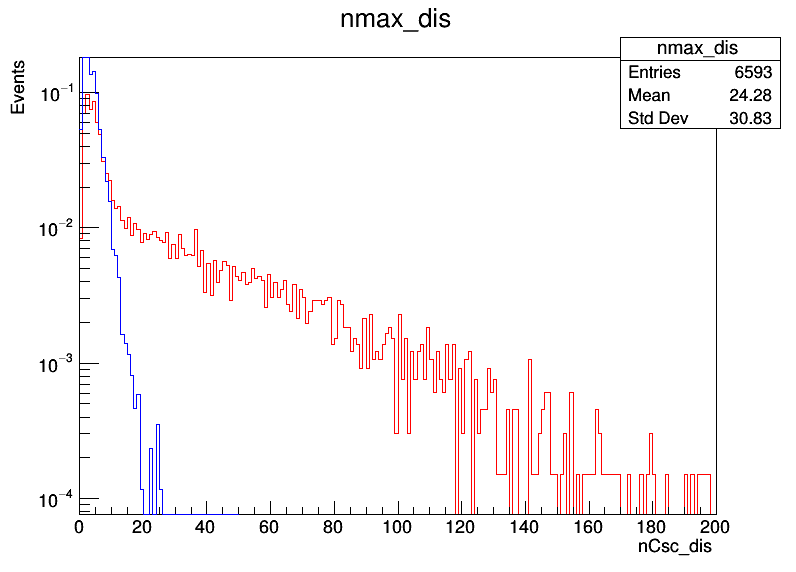

In [81]:
c2 = rt.TCanvas('c2','c2', 800, 600)
h['nmax_dis'] = create_TH1D(n_max_dis, axis_title=['nCsc_dis', 'Events'], name='nmax_dis', binning=[500,0,500])
h['nmax_dis'].SetLineColor(4)
h['nmax_prompt'] = create_TH1D(n_max_prompt, axis_title=['nmax_prompt', 'Events'], name='nmax_prompt', binning=[500,0,500])
h['nmax_prompt'].SetLineColor(2)
c2.SetLogy()
#h['llp_eta'].SetStats(0)
h['nmax_dis'].Scale(1.0/h['nmax_dis'].Integral())
h['nmax_prompt'].Scale(1.0/h['nmax_prompt'].Integral())
h['nCsc_dis'].SetLineColor(8)
h['nCsc_prompt'].SetLineColor(6)

#HISTO INFO
print h['nmax_prompt'].Integral(20,100)
print h['nmax_dis'].Integral(20,100)

#DRAW HISTOGRAMS
h['nmax_prompt'].GetXaxis().SetRangeUser(0,50)
h['nmax_prompt'].Draw('histo')
#h['nmax_dis'].Draw('histo+same')
#h['nCsc_dis'].Draw('histo+same')
h['nCsc_prompt'].Draw('histo+same')

c2.Draw()
c2.SaveAs("muon_roi_trigger_bkg_like.pdf")

h['nmax_dis'].GetXaxis().SetRangeUser(0,200)
h['nmax_dis'].SetLineColor(2)
h['nCsc_dis'].SetLineColor(6)
h['nmax_dis'].Draw('histo')
h['nCsc_dis'].Draw('histo+same')
c2.SaveAs("muon_roi_trigger_signal_like.pdf")

h['nmax_dis'].GetXaxis().SetRangeUser(0,200)
h['nmax_dis'].SetLineColor(2)
h['nmax_prompt'].SetLineColor(4)
h['nmax_dis'].Draw('histo')
h['nmax_prompt'].Draw('histo+same')
c2.SaveAs("muon_roi_trigger_signal_vs_bkg.pdf")
